## Colab Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pip installs

In [ ]:
!pip install torch tiktoken numpy pandas

## Model from scratch

In [3]:
import torch
import torch.nn as nn
import math

from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps")

# A helper config class that contains model parameters
class Config:
    embed_dropout = 0.1
    ff_dropout = 0.1
    attn_dropout = 0.1

    num_embed = 768
    num_heads = 12
    num_blocks = 12

    batch_size = 32

    def __init__(self, vocab_size, max_seq_len) -> None:
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len

In [4]:
class SelfAttention(nn.Module):

    def __init__(self, config: Config):
        super().__init__()

        if config.num_embed % config.num_heads != 0:
            raise ValueError("num_embed % num_heads != 0")

        self.num_embed = config.num_embed
        self.num_heads = config.num_heads

        self.c_attn = nn.Linear(config.num_embed, 3 * config.num_embed)  # key, query, value
        self.c_proj = nn.Linear(config.num_embed, config.num_embed)

        # regularization
        self.attn_dropout = nn.Dropout(config.attn_dropout)
        self.resid_dropout = nn.Dropout(config.ff_dropout)

        # Mask that makes sure that attention only affects left tokens (previous, not future ones)
        self.register_buffer("bias", torch.tril(torch.ones(config.max_seq_len, config.max_seq_len))
                                     .view(1, 1, config.max_seq_len, config.max_seq_len))

    def forward(self, x):
        B, T, C = x.size()  # batch size, seq len, num_embed

        # query, key, value for every head in batch
        query, key, value = self.c_attn(x).split(self.num_embed, dim=2)

        key = key.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        query = query.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        value = value.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)

        # Causal self attention
        atn = (query @ key.transpose(-2, -1)) * (1.0 / math.sqrt(key.size(-1)))
        atn = atn.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        atn = F.softmax(atn, dim=-1)
        atn = self.attn_dropout(atn)

        y = atn @ value
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        return y

class Block(nn.Module):
    def __init__(self, config: Config):
        super().__init__()

        self.ln_1 = nn.LayerNorm(config.num_embed)

        self.attention = SelfAttention(config)

        self.ln_2 = nn.LayerNorm(config.num_embed)

        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.num_embed, 4 * config.num_embed),
            c_proj  = nn.Linear(4 * config.num_embed, config.num_embed),
            act     = nn.GELU(),
            dropout = nn.Dropout(config.ff_dropout),
        ))

        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))

    def forward(self, x):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))

        return x

class GPT(nn.Module):
    def __init__(self, config: Config) -> None:
        super().__init__()

        self.max_seq_len = config.max_seq_len
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.num_embed),
            wpe = nn.Embedding(config.max_seq_len, config.num_embed),
            dropout = nn.Dropout(config.embed_dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.num_blocks)]),
            ln_f = nn.LayerNorm(config.num_embed)
        ))

        self.head = nn.Linear(config.num_embed, config.vocab_size)

    def forward(self, x, targets=None):
        # x.shape = (Batches, Seq length)

        seq_len = x.size(1)

        if seq_len > self.max_seq_len:
            raise ValueError("Sequence length is > max allowed length")

        token_emb = self.transformer.wte(x)  # Batch size, seq length, num_embed

        positions = torch.arange(0, seq_len,
                               dtype=torch.long,
                               device=device).unsqueeze(0)  # (1, max_seq_len)

        pos_emb = self.transformer.wpe(positions)  # 1, max_seq_len, num_embed

        x = self.transformer.dropout(token_emb + pos_emb)

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)

        logits = self.head(x)
        # print(f"logits.shape: {logits.shape}")
        # print(f"targets.shape: {targets.shape}")

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)
            # print(f"LOGITS: {logits}\nTargets: {targets}")

        return logits, loss

    def generate(self, xs, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):

        for _ in range(max_new_tokens):
            if xs.size(1) > self.max_seq_len:
                x = xs[:, -self.max_seq_len:]
            else:
                x = xs

            logits, _ = self(x)

            # Taking last logits
            logits = logits[:, -1, :] / temperature  # Also scaling by temperature

            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)

            # We can either sample from distribution or choose using top_k
            if do_sample:
                x_next = torch.multinomial(probs, num_samples=1)
            else:
                _, x_next = torch.topk(probs, k=1, dim=-1)

            xs = torch.cat((xs, x_next), dim=1)  # Adding a chosen token to the sequence
        return xs

In [5]:
# Tokenizer

import tiktoken

enc = tiktoken.get_encoding("gpt2")

[15496, 11, 340, 338, 502, 0]


In [6]:
enc.eot_token

50256

In [7]:
vocab_size = enc.n_vocab

print(f"vocab size: {vocab_size}")

vocab size: 50257


We will be processing several batches in parallel to accelerate training process

In [8]:
max_seq_len = 50

config = Config(vocab_size, max_seq_len)

We can see that the model gives us random output. Let's train it!

In [9]:
import pandas as pd
import random

def pad_sequence(encoded_sequence, max_seq_len):
    seq_len = len(encoded_sequence)

    for i in range(max_seq_len - seq_len):
        encoded_sequence.append(enc.eot_token)

def strip_sequence(encoded_sequence, max_seq_len):
    if len(encoded_sequence) > max_seq_len:
        return encoded_sequence[:max_seq_len]
    return encoded_sequence

def preprocess_entry(tokenizer, max_seq_len, entry):
    encoded = tokenizer.encode(entry[1][0])
    if len(encoded) > max_seq_len:
        encoded = strip_sequence(encoded, max_seq_len)
    encoded.append(tokenizer.eot_token)
    return encoded

class JokeDataset(Dataset):
    def __init__(self, file, tokenizer, max_seq_len):

        df = pd.read_csv(file, index_col=0)

        self.jokes = []
        for row in df.iterrows():
            encoded = preprocess_entry(tokenizer, max_seq_len, row)
            self.jokes.extend(encoded)

    def __len__(self):
        return len(self.jokes)

    def __getitem__(self, idx):
        if len(self.jokes) - idx < max_seq_len + 1:
            idx = len(self.jokes) - max_seq_len - 1

        encoded_sample = self.jokes[idx:idx + max_seq_len + 1]

        x = encoded_sample[:max_seq_len]
        y = encoded_sample[1:]

        return torch.tensor(x), torch.tensor(y)

In [10]:
shortjokes_path = "/content/drive/MyDrive/IU/Semester_7/PMLDL_JokeGPT/shortjokes.csv"

train_dataset = JokeDataset(shortjokes_path, enc, config.max_seq_len)

In [12]:
torch.autograd.set_detect_anomaly(False)

In [13]:
model = GPT(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model_path = "/content/drive/MyDrive/IU/Semester_7/PMLDL_JokeGPT/GPTFromScratch"

In [14]:
import tqdm
import time

num_workers = 2
grad_norm_clip = 1.0

train_loader = DataLoader(
                train_dataset,
                sampler=torch.utils.data.RandomSampler(train_dataset,
                                                        replacement=True,
                                                        num_samples=int(1e10)),
                shuffle=False,
                pin_memory=True,
                batch_size=config.batch_size,
                num_workers=num_workers,
                )

model.train()
epochs = 20
max_iters = 500
iter_num = 0
iter_time = time.time()
data_iter = iter(train_loader)

best_loss = 4
last_loss = best_loss

losses = []

for epoch in tqdm.tqdm(range(epochs)):
    for curr_iter in range(max_iters):

        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader)  # Start again if reached the end
            batch = next(data_iter)

        batch = [t.to(device) for t in batch]
        x, y = batch

        logits, loss = model(x, y)

        model.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()

        if curr_iter % 100 == 0:
            print(f"epoch: {epoch}; iter_num: {iter_num}; loss: {loss}")
            if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), f"{model_path}_{epoch}_{iter_num}_{loss}")
        last_loss = loss
    losses.append(last_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0; iter_num: 0; loss: 10.999482154846191
epoch: 0; iter_num: 0; loss: 6.497827529907227
epoch: 0; iter_num: 0; loss: 6.315689563751221
epoch: 0; iter_num: 0; loss: 6.0192952156066895
epoch: 0; iter_num: 0; loss: 5.842006206512451


  5%|▌         | 1/20 [03:46<1:11:36, 226.14s/it]

epoch: 1; iter_num: 0; loss: 5.657104969024658
epoch: 1; iter_num: 0; loss: 5.780244827270508
epoch: 1; iter_num: 0; loss: 5.328470230102539
epoch: 1; iter_num: 0; loss: 5.435688018798828
epoch: 1; iter_num: 0; loss: 5.135679244995117


 10%|█         | 2/20 [07:35<1:08:19, 227.76s/it]

epoch: 2; iter_num: 0; loss: 5.374339580535889
epoch: 2; iter_num: 0; loss: 5.371807098388672
epoch: 2; iter_num: 0; loss: 5.3074564933776855
epoch: 2; iter_num: 0; loss: 5.178530693054199
epoch: 2; iter_num: 0; loss: 5.16877555847168


 15%|█▌        | 3/20 [11:23<1:04:39, 228.23s/it]

epoch: 3; iter_num: 0; loss: 5.198282241821289
epoch: 3; iter_num: 0; loss: 5.117187976837158
epoch: 3; iter_num: 0; loss: 4.981469631195068
epoch: 3; iter_num: 0; loss: 5.031808376312256
epoch: 3; iter_num: 0; loss: 5.095453262329102


 20%|██        | 4/20 [15:12<1:00:56, 228.52s/it]

epoch: 4; iter_num: 0; loss: 4.7794718742370605
epoch: 4; iter_num: 0; loss: 4.827373504638672
epoch: 4; iter_num: 0; loss: 4.866889953613281
epoch: 4; iter_num: 0; loss: 5.021045207977295
epoch: 4; iter_num: 0; loss: 4.967208385467529


 25%|██▌       | 5/20 [19:02<57:12, 228.81s/it]  

epoch: 5; iter_num: 0; loss: 4.7825446128845215
epoch: 5; iter_num: 0; loss: 4.808016777038574
epoch: 5; iter_num: 0; loss: 5.010392189025879
epoch: 5; iter_num: 0; loss: 4.70461368560791
epoch: 5; iter_num: 0; loss: 4.85282564163208


 30%|███       | 6/20 [22:51<53:23, 228.85s/it]

epoch: 6; iter_num: 0; loss: 4.7631635665893555
epoch: 6; iter_num: 0; loss: 4.641072750091553
epoch: 6; iter_num: 0; loss: 4.606839656829834
epoch: 6; iter_num: 0; loss: 5.0915703773498535
epoch: 6; iter_num: 0; loss: 4.644153594970703


 35%|███▌      | 7/20 [26:40<49:35, 228.91s/it]

epoch: 7; iter_num: 0; loss: 4.5101118087768555
epoch: 7; iter_num: 0; loss: 4.751358509063721
epoch: 7; iter_num: 0; loss: 4.4253249168396
epoch: 7; iter_num: 0; loss: 4.272685527801514
epoch: 7; iter_num: 0; loss: 4.57515811920166


 40%|████      | 8/20 [30:29<45:48, 229.01s/it]

epoch: 8; iter_num: 0; loss: 4.540579795837402
epoch: 8; iter_num: 0; loss: 4.551905632019043
epoch: 8; iter_num: 0; loss: 4.697862148284912
epoch: 8; iter_num: 0; loss: 4.65164852142334
epoch: 8; iter_num: 0; loss: 4.396605014801025


 45%|████▌     | 9/20 [34:18<42:01, 229.20s/it]

epoch: 9; iter_num: 0; loss: 4.293979167938232
epoch: 9; iter_num: 0; loss: 4.370739459991455
epoch: 9; iter_num: 0; loss: 4.266968250274658
epoch: 9; iter_num: 0; loss: 4.426673412322998
epoch: 9; iter_num: 0; loss: 4.400434494018555
epoch: 10; iter_num: 0; loss: 4.306269645690918
epoch: 10; iter_num: 0; loss: 4.482110977172852
epoch: 10; iter_num: 0; loss: 4.427398681640625
epoch: 10; iter_num: 0; loss: 4.638190746307373
epoch: 10; iter_num: 0; loss: 4.197810173034668


 55%|█████▌    | 11/20 [41:57<34:23, 229.29s/it]

epoch: 11; iter_num: 0; loss: 4.405765056610107
epoch: 11; iter_num: 0; loss: 4.524531364440918
epoch: 11; iter_num: 0; loss: 4.343035697937012
epoch: 11; iter_num: 0; loss: 4.208868026733398
epoch: 11; iter_num: 0; loss: 4.303743839263916


 60%|██████    | 12/20 [45:47<30:34, 229.35s/it]

epoch: 12; iter_num: 0; loss: 4.277750015258789
epoch: 12; iter_num: 0; loss: 4.4647722244262695
epoch: 12; iter_num: 0; loss: 4.552567005157471
epoch: 12; iter_num: 0; loss: 4.191070079803467
epoch: 12; iter_num: 0; loss: 4.311422348022461


 65%|██████▌   | 13/20 [49:36<26:45, 229.33s/it]

epoch: 13; iter_num: 0; loss: 4.329257011413574
epoch: 13; iter_num: 0; loss: 4.400514125823975
epoch: 13; iter_num: 0; loss: 4.291391849517822
epoch: 13; iter_num: 0; loss: 4.423242092132568
epoch: 13; iter_num: 0; loss: 4.3037238121032715


 70%|███████   | 14/20 [53:25<22:56, 229.41s/it]

epoch: 14; iter_num: 0; loss: 3.8789706230163574
epoch: 14; iter_num: 0; loss: 4.132814884185791
epoch: 14; iter_num: 0; loss: 4.229280948638916
epoch: 14; iter_num: 0; loss: 4.331777572631836
epoch: 14; iter_num: 0; loss: 4.134678363800049


 75%|███████▌  | 15/20 [57:17<19:10, 230.04s/it]

epoch: 15; iter_num: 0; loss: 4.1211934089660645
epoch: 15; iter_num: 0; loss: 3.8447048664093018
epoch: 15; iter_num: 0; loss: 4.124168395996094
epoch: 15; iter_num: 0; loss: 4.068563461303711
epoch: 15; iter_num: 0; loss: 4.123155117034912


 80%|████████  | 16/20 [1:01:09<15:22, 230.70s/it]

epoch: 16; iter_num: 0; loss: 4.293248176574707


 80%|████████  | 16/20 [1:01:26<15:21, 230.41s/it]


KeyboardInterrupt: ignored

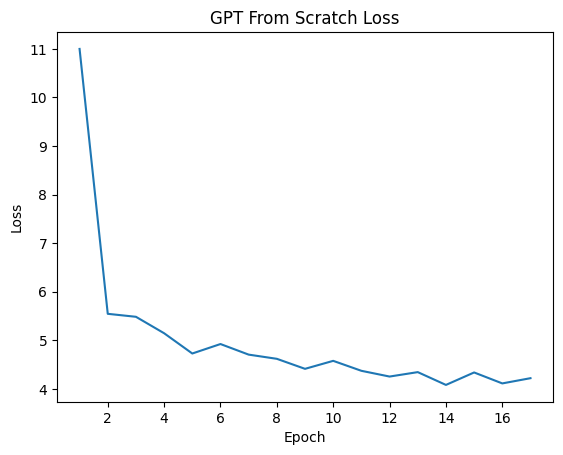

In [21]:
plt.plot(epochs, losses)
plt.title('GPT From Scratch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/IU/Semester_7/PMLDL_JokeGPT/GPTFromScratch/eos_model_shortjokes_only"

torch.save(model.state_dict(), model_path)

## Model Testing

The following code is used to load and test the model

In [ ]:
import tiktoken

load_model_path = "/content/drive/MyDrive/IU/Semester_7/PMLDL_JokeGPT/GPTFromScratch/eos_model_shortjokes_only"
enc = tiktoken.get_encoding("gpt2")

max_seq_len = 50

config = Config(vocab_size, max_seq_len)
model = GPT(config).to(device)
model.load_state_dict(torch.load(load_model_path))
model.eval()

In [ ]:
starting_string = "My son"

start = torch.tensor([enc.encode(starting_string)], dtype=torch.long, device=device)

output = model.generate(xs = start, max_new_tokens=30, do_sample=True)[0].tolist()

try:
    end_index = output.index(enc.eot_token)
    output = enc.decode(output[:end_index])
except:
    output = "Please try again!"

print(output)